# PART B- Analysing CSV Data

### Importing required libraries for all the PART B tasks

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pyspark.sql.functions import udf,col,date_format
from pyspark.sql.functions import *
from pyspark.sql.types import DateType

### STEP-01 Importing pyspark and Initializing SPARK

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'
# create entry points to spark
from pyspark import SparkContext,SparkConf # Spark
from pyspark.sql import SparkSession # Spark SQL

# We add this line to avoid an error : "Cannot run multiple SparkContexts at once". 
# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate()

conf = SparkConf()
conf.set('spark.app.name','Analysing CSV data')
conf.set('spark.master','local[*]')  # Use all cores in the machine
conf.set('spark.ui.port','4040') # set default port 4040

# If there is no existing spark context, we now create a new context
if (sc is None):
    sc = SparkContext(conf = conf)
    
my_spark = SparkSession(sparkContext=sc)\
        .builder\
        .appName("MongoDB and Apache Spark")\
        .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.11:2.4.0")\
        .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/fit5202_db.wk04_coll")\
        .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/fit5202_db.wk04_coll")\
        .getOrCreate()

### Step 02: Create Dataframe

**Creating a data frame from the input csv file using spark session object 'my_spark'**

In [4]:
crime_stat_df  = my_spark.read.csv('Crime_Statistics_SA_2010_present.csv',header=True,inferSchema=True)

In [5]:
# showing top 3 rows of the dataframe
crime_stat_df.show(3)

+-------------+-----------------+-------------------+---------------------------+---------------------------+---------------------------+-------------+
|Reported Date|Suburb - Incident|Postcode - Incident|Offence Level 1 Description|Offence Level 2 Description|Offence Level 3 Description|Offence Count|
+-------------+-----------------+-------------------+---------------------------+---------------------------+---------------------------+-------------+
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       FRAUD DECEPTION A...|       Obtain benefit by...|            2|
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       PROPERTY DAMAGE A...|       Other property da...|            2|
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       SERIOUS CRIMINAL ...|        SCT - Non Residence|            1|
+-------------+-----------------+-------------------+---------------------------+-------

**Used .count() to calculate total number of records present in the data frame**

In [6]:
print('Total records in the data frame are: '+str(crime_stat_df.count()))

Total records in the data frame are: 727408


**Schema of the data frame**

In [7]:
crime_stat_df.printSchema()

root
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Offence Count: integer (nullable = true)



### Step 03: Write to Database

**Loading data frame into MongoDB**

In [11]:
crime_stat_df.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").save()

### Step 04: Read from Database

**Reading from MongoDB** 

In [12]:
crime_stat_df_mongodb = my_spark.read.format("com.mongodb.spark.sql.DefaultSource").load()

In [13]:
# schema of the dataframe
crime_stat_df_mongodb.printSchema()

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



In [ ]:
# Top 3 rows of the data frame
crime_stat_df_mongodb.show(3)

### Step 05: Calculate the statistics of numeric and string columns

##### Count, Mean, Standard Deviation, Min and Max values of "Offence Counts"

In [7]:
crime_stat_df_mongodb.describe('Offence Count').show()

+-------+------------------+
|summary|     Offence Count|
+-------+------------------+
|  count|            727407|
|   mean|1.1715174585892079|
| stddev|0.5787050930378095|
|    min|                 1|
|    max|                28|
+-------+------------------+



#### Reported Date Count, Min and Max values

In [13]:
crime_stat_df_mongodb.describe('Reported Date').show()

+-------+-------------+
|summary|Reported Date|
+-------+-------------+
|  count|       727407|
|   mean|         null|
| stddev|         null|
|    min|    1/01/2011|
|    max|    9/12/2018|
+-------+-------------+



In [16]:
# crime_stat_df_mongodb.select('Reported Date').orderBy('Reported Date',ascending=True).show(30)

**Minimum and maximum dates incorrect:
If we run the code commented in above cell, we see that the dates,as they are strings, are sotted by days first, months after and year at last. DataFrame sorts them as it would sort a normal string.**

### Step 06: Change the data type of a column

**The dataframe consists of null values in one of the columns. So before changing to datetype we remove the null valued rows**

In [17]:
crime_stat_df_mongodb.where(col('Reported Date').isNull()).show()

+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+
|Offence Count|Offence Level 1 Description|Offence Level 2 Description|Offence Level 3 Description|Postcode - Incident|Reported Date|Suburb - Incident|                 _id|
+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+
|         null|                       null|                       null|                       null|               null|         null|             null|[5d72105d4e51663e...|
+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+



**One of the observations contains NULL values.So before we convert column "Reported Date" into datetime format, we need to remove the NULL valued observations**

In [18]:
crime_stat_df_mongodb = crime_stat_df_mongodb.filter(crime_stat_df_mongodb['Reported Date'].isNotNull())

In [20]:
crime_stat_df_mongodb.where(col('Reported Date').isNull()).show()

+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+---+
|Offence Count|Offence Level 1 Description|Offence Level 2 Description|Offence Level 3 Description|Postcode - Incident|Reported Date|Suburb - Incident|_id|
+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+---+
+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+---+



NULL row has been removed

In [22]:
# function used to convert string date into datetime
toDatefunc = udf(lambda x: datetime.strptime(x,'%d/%m/%Y'),DateType())

* strptime() method from datetime converts the date into a given format and returns in with a changed data type which is DateType() in our case


In [23]:
crime_stat_df_mongodb = crime_stat_df_mongodb.withColumn("Reported Date_DateType",toDatefunc(col('Reported Date')))

* udf function created is applied to the entire string date column and the result is stored in "Reported Date_DateType" column

In [24]:
crime_stat_df_mongodb.show(2,truncate=False)

+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------------+----------------------+
|Offence Count|Offence Level 1 Description|Offence Level 2 Description|Offence Level 3 Description|Postcode - Incident|Reported Date|Suburb - Incident|_id                       |Reported Date_DateType|
+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------------+----------------------+
|1            |OFFENCES AGAINST PROPERTY  |SERIOUS CRIMINAL TRESPASS  |SCT - Residence            |5022               |29/07/2016   |GRANGE           |[5d7210594e51663ee97e674a]|2016-07-29            |
|1            |OFFENCES AGAINST PROPERTY  |THEFT AND RELATED OFFENCES |Theft from motor vehicle   |5022               |29/07/2016   |GRANGE           |[5d7210594e51663ee97e674b]|2016-07-29    

In [25]:
crime_stat_df_mongodb.printSchema()

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- Reported Date_DateType: date (nullable = true)



### Step 07: Preliminary data analysis

#### How many level 2 offences are there? Display the list of level 2 offences.

In [18]:
crime_stat_df_mongodb.filter(crime_stat_df_mongodb['Offence Level 2 Description'] !='null').\
select('Offence Level 2 Description').distinct().count()

9

In [19]:
crime_stat_df_mongodb.filter(crime_stat_df_mongodb['Offence Level 2 Description'] !='null').\
select('Offence Level 2 Description').distinct().show(truncate=False)

+------------------------------------+
|Offence Level 2 Description         |
+------------------------------------+
|ROBBERY AND RELATED OFFENCES        |
|PROPERTY DAMAGE AND ENVIRONMENTAL   |
|SEXUAL ASSAULT AND RELATED OFFENCES |
|HOMICIDE AND RELATED OFFENCES       |
|ACTS INTENDED TO CAUSE INJURY       |
|SERIOUS CRIMINAL TRESPASS           |
|OTHER OFFENCES AGAINST THE PERSON   |
|FRAUD DECEPTION AND RELATED OFFENCES|
|THEFT AND RELATED OFFENCES          |
+------------------------------------+



#### What is the number of offences against the person?

In [35]:
crime_stat_df_mongodb.filter(crime_stat_df_mongodb['Offence Level 1 Description']=='OFFENCES AGAINST THE PERSON').groupby('Offence Level 1 Description').sum('Offence Count').show(truncate=False)

+---------------------------+------------------+
|Offence Level 1 Description|sum(Offence Count)|
+---------------------------+------------------+
|OFFENCES AGAINST THE PERSON|175644            |
+---------------------------+------------------+



#### How many serious criminal tresspasses with more than 1 offence count?

In [36]:
crime_stat_df_mongodb.filter(crime_stat_df_mongodb['Offence Level 2 Description']=='SERIOUS CRIMINAL TRESPASS').filter(crime_stat_df_mongodb['Offence Count']>1).count()

8579

#### What percentage of crimes are offences against the property?

In [39]:
total_offences_property = crime_stat_df_mongodb.filter(crime_stat_df_mongodb['Offence Level 1 Description']=='OFFENCES AGAINST PROPERTY').groupby().sum('Offence Count').collect()[0][0]
total_offences_property

676526

In [41]:
total_crimes = crime_stat_df_mongodb.groupby().sum('Offence Count').collect()[0][0]
total_crimes

852170

In [44]:
print('Percentage of crimes that are against property = {}'.format((total_offences_property/total_crimes)*100))

Percentage of crimes that are against property = 79.3886196416208


### Step 08: Exploratory data analysis

#### Find the number of crimes per year. Plot the graph and explain your understanding of the graph?

For plotting and further analysis i have added three new columns named Year, Month and Day<br>
* year(),month() and dayofmonth() methods from datetime library have been used to extract year,month and day from the datetime column 'Reported Date_DateType'
* used .toPandas() for converting dataframe into pandas for plotting

In [30]:
crime_stat_df_mongodb = crime_stat_df_mongodb.withColumn('Year',year(col('Reported Date_DateType')))
crime_stat_df_mongodb = crime_stat_df_mongodb.withColumn('Month',month(col('Reported Date_DateType')))
crime_stat_df_mongodb = crime_stat_df_mongodb.withColumn('Day',dayofmonth(col('Reported Date_DateType')))
# showing the newly created columns
crime_stat_df_mongodb.select('Year','Month','Day').show(4,truncate=False)

+----+-----+---+
|Year|Month|Day|
+----+-----+---+
|2016|7    |29 |
|2016|7    |29 |
|2016|7    |29 |
|2016|7    |29 |
+----+-----+---+
only showing top 4 rows



In [32]:
crime_per_year = crime_stat_df_mongodb.groupby('Year').agg(sum('Offence Count').alias('Offence Count')).sort('Year').toPandas()

* used .toPandas() for converting dataframe into pandas for plotting

In [33]:
crime_per_year

,Year,Offence Count
0,2010,61402
1,2011,122204
2,2012,112962
3,2013,106782
4,2014,101750
5,2015,105656
6,2016,107593
7,2017,50159
8,2018,55758
9,2019,27904


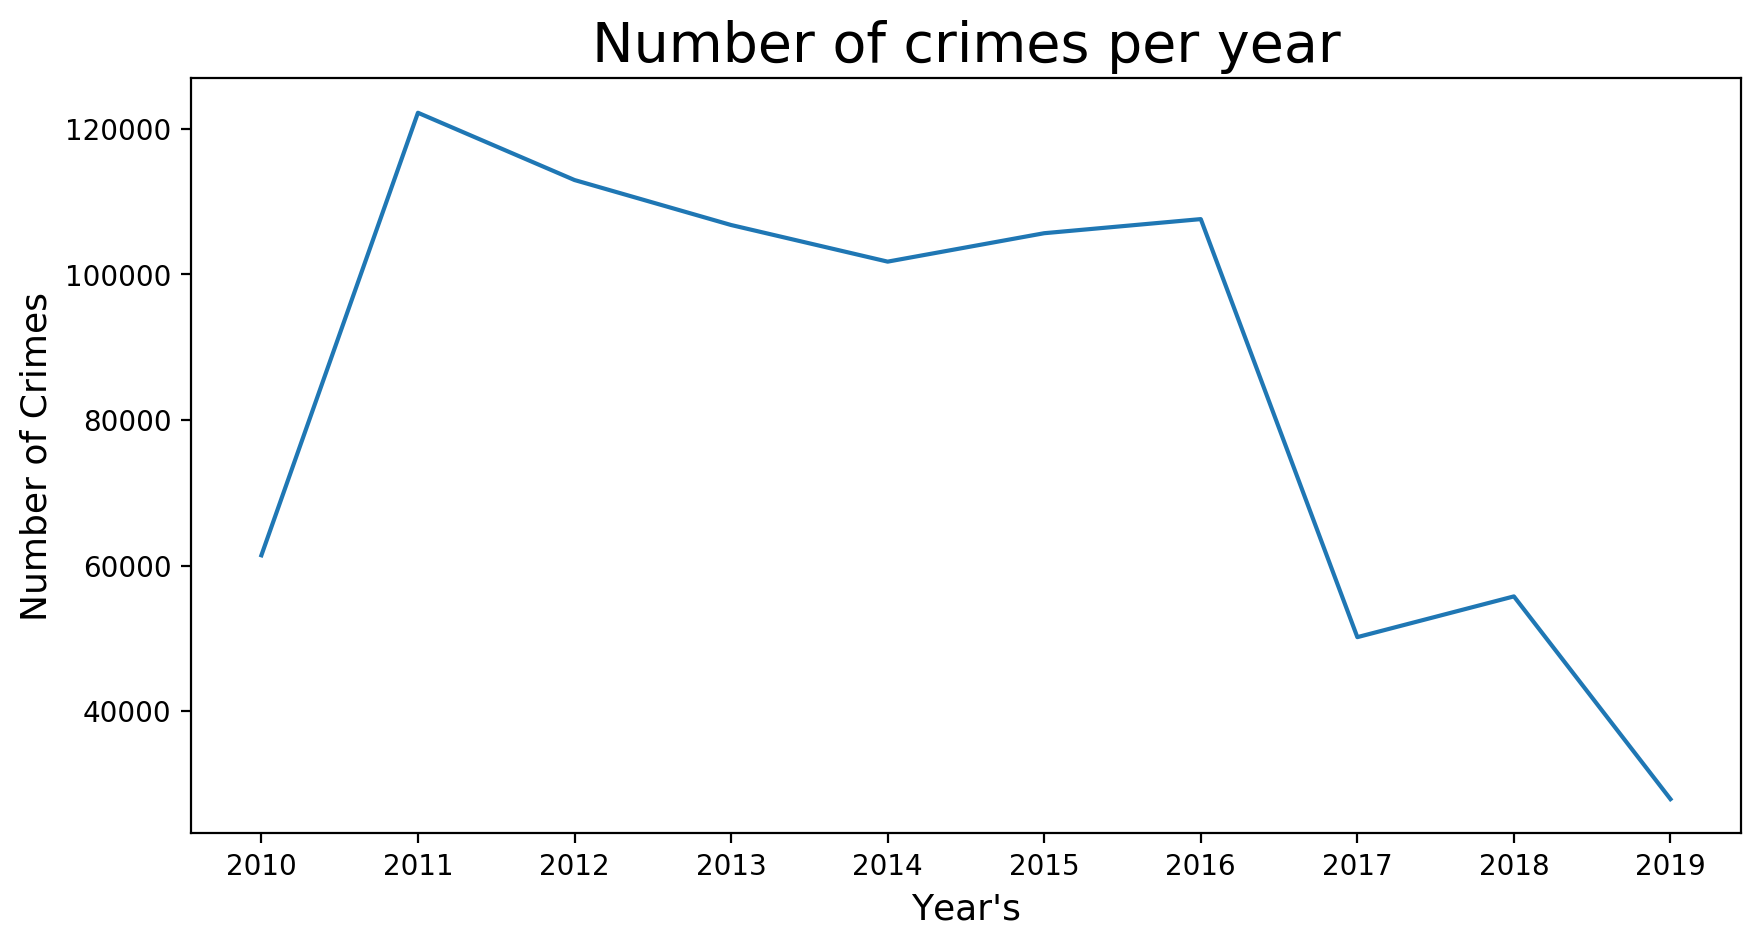

In [77]:
# crime_per_year
plt.figure(figsize=(10,5),dpi=200)
plt.plot(crime_per_year['Year'],crime_per_year['Offence Count'])
plt.xticks(crime_per_year['Year']) # x axis values
plt.ylabel('Number of Crimes',fontsize=13) # y axis labels
plt.xlabel('Year\'s',fontsize=13) #x axis labels
plt.title('Number of crimes per year',fontsize=20)
plt.show()

From the graph we can interpret that the number of crimes in Australia has been very high during years 2011-2016. &nbsp; <br>  2011 saw nearly 100% increase in crimes compared to 2010 <br>2017 saw a decrease of nearly 50% in crimes as compared to 2016.

#### Find the number of crimes per month. Plot the graph and explain your understanding of the graph?

In [35]:
crime_per_month = crime_stat_df_mongodb.groupby('Month').agg(sum('Offence Count').alias('Offence Count')).sort('Month').toPandas()

In [36]:
crime_per_month

,Month,Offence Count
0,1,77516
1,2,70429
2,3,74931
3,4,60037
4,5,64246
5,6,60687
6,7,70954
7,8,72839
8,9,72595
9,10,77153


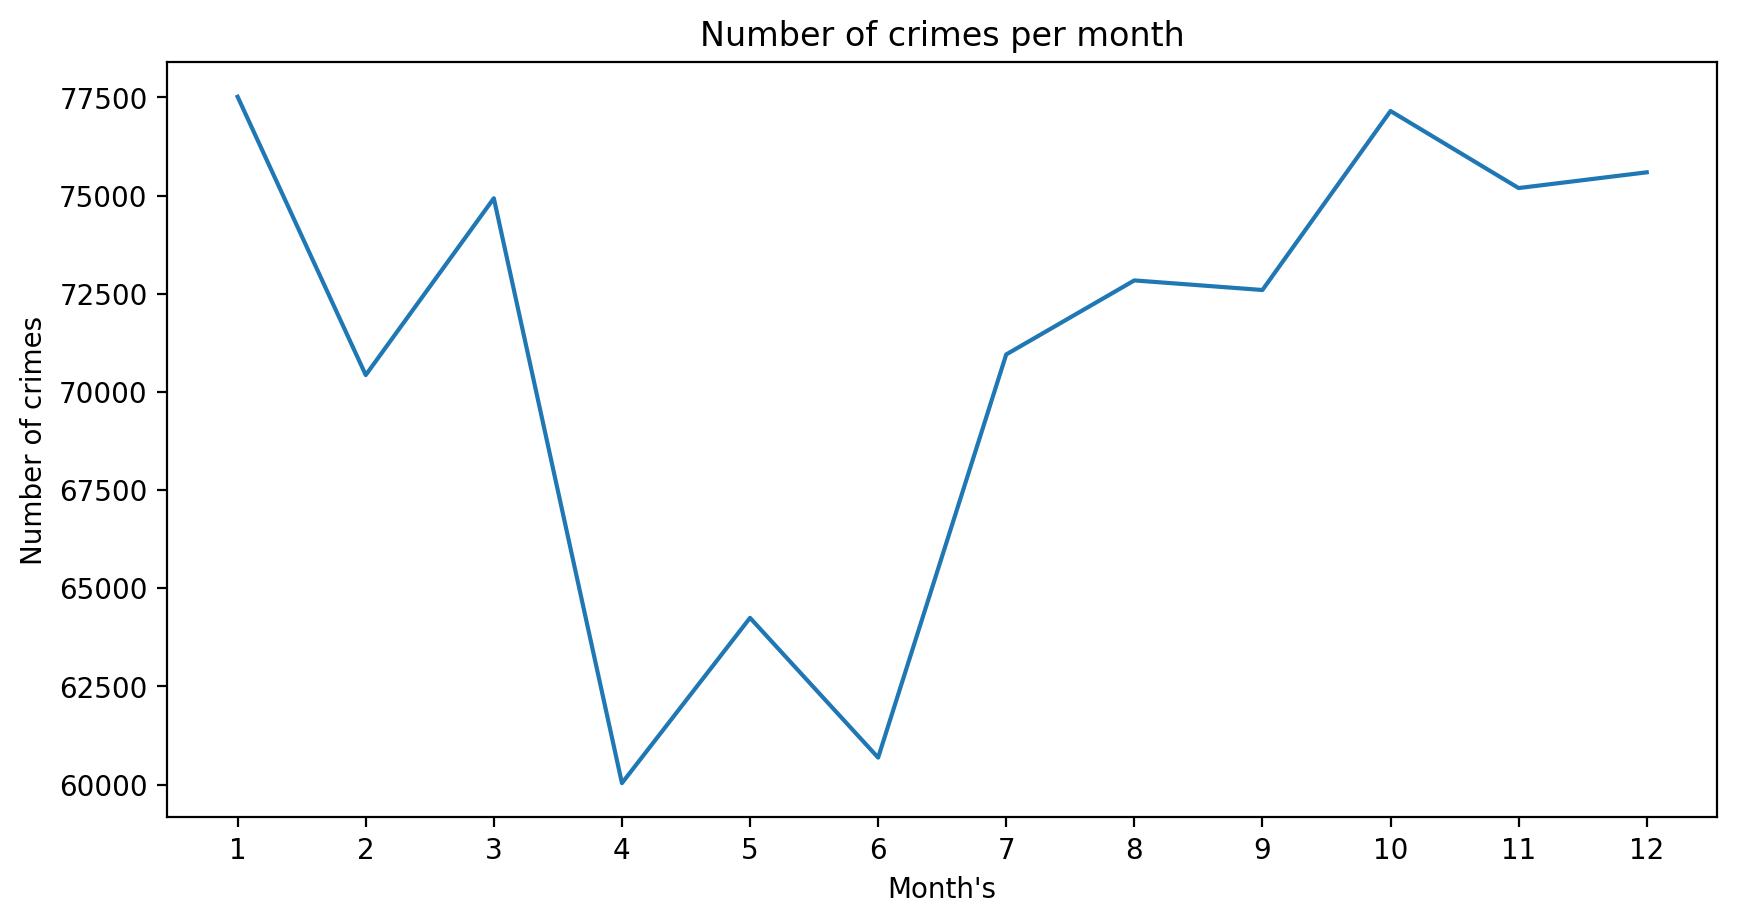

In [78]:
plt.figure(figsize=(10,5),dpi=200)
plt.plot(crime_per_month['Month'],crime_per_month['Offence Count'])
plt.xticks(crime_per_month['Month']) # x axis values
plt.ylabel('Number of crimes') # y axis labels
plt.xlabel('Month\'s') # x axis labels
plt.title('Number of crimes per month')
plt.show()

* Month's 4-6 have the least number of crimes across all the years
* Peak values are during months 1 and 11 

**Where do most crimes take place? Find the top 20 suburbs (which would also display postcode for e.g. Caulfield-3162 )?. Plot the graph and explain your understanding of the graph?**

* Used **concat()** function to join values of two columns, 'Suburb - Incident' and 'Postcode - Incident' and created a new column **"Suburb-postcode"**
* **lit('-')** assigns '-' as a seperator between the two to be concatenated columns

In [45]:
crime_stat_df_mongodb = crime_stat_df_mongodb.withColumn('Suburb-postcode',concat(col('Suburb - Incident'),lit('-'),col('Postcode - Incident')))

In [46]:
crime_stat_df_mongodb.printSchema()

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- Reported Date_DateType: date (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Suburb-postcode: string (nullable = true)



In [47]:
crime_stat_df_mongodb.show(3)

+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+----------------------+----+-----+---+---------------+
|Offence Count|Offence Level 1 Description|Offence Level 2 Description|Offence Level 3 Description|Postcode - Incident|Reported Date|Suburb - Incident|                 _id|Reported Date_DateType|Year|Month|Day|Suburb-postcode|
+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+----------------------+----+-----+---+---------------+
|            1|       OFFENCES AGAINST ...|       SERIOUS CRIMINAL ...|            SCT - Residence|               5022|   29/07/2016|           GRANGE|[5d7210594e51663e...|            2016-07-29|2016|    7| 29|    GRANGE-5022|
|            1|       OFFENCES AGAINST ...|       THEFT AND RELATED...|       Theft from mot

In [48]:
crime_per_suburb = crime_stat_df_mongodb.groupby('Suburb-postcode').agg(sum('Offence Count').alias('Offence Count')).orderBy('Offence Count',ascending=False).toPandas()

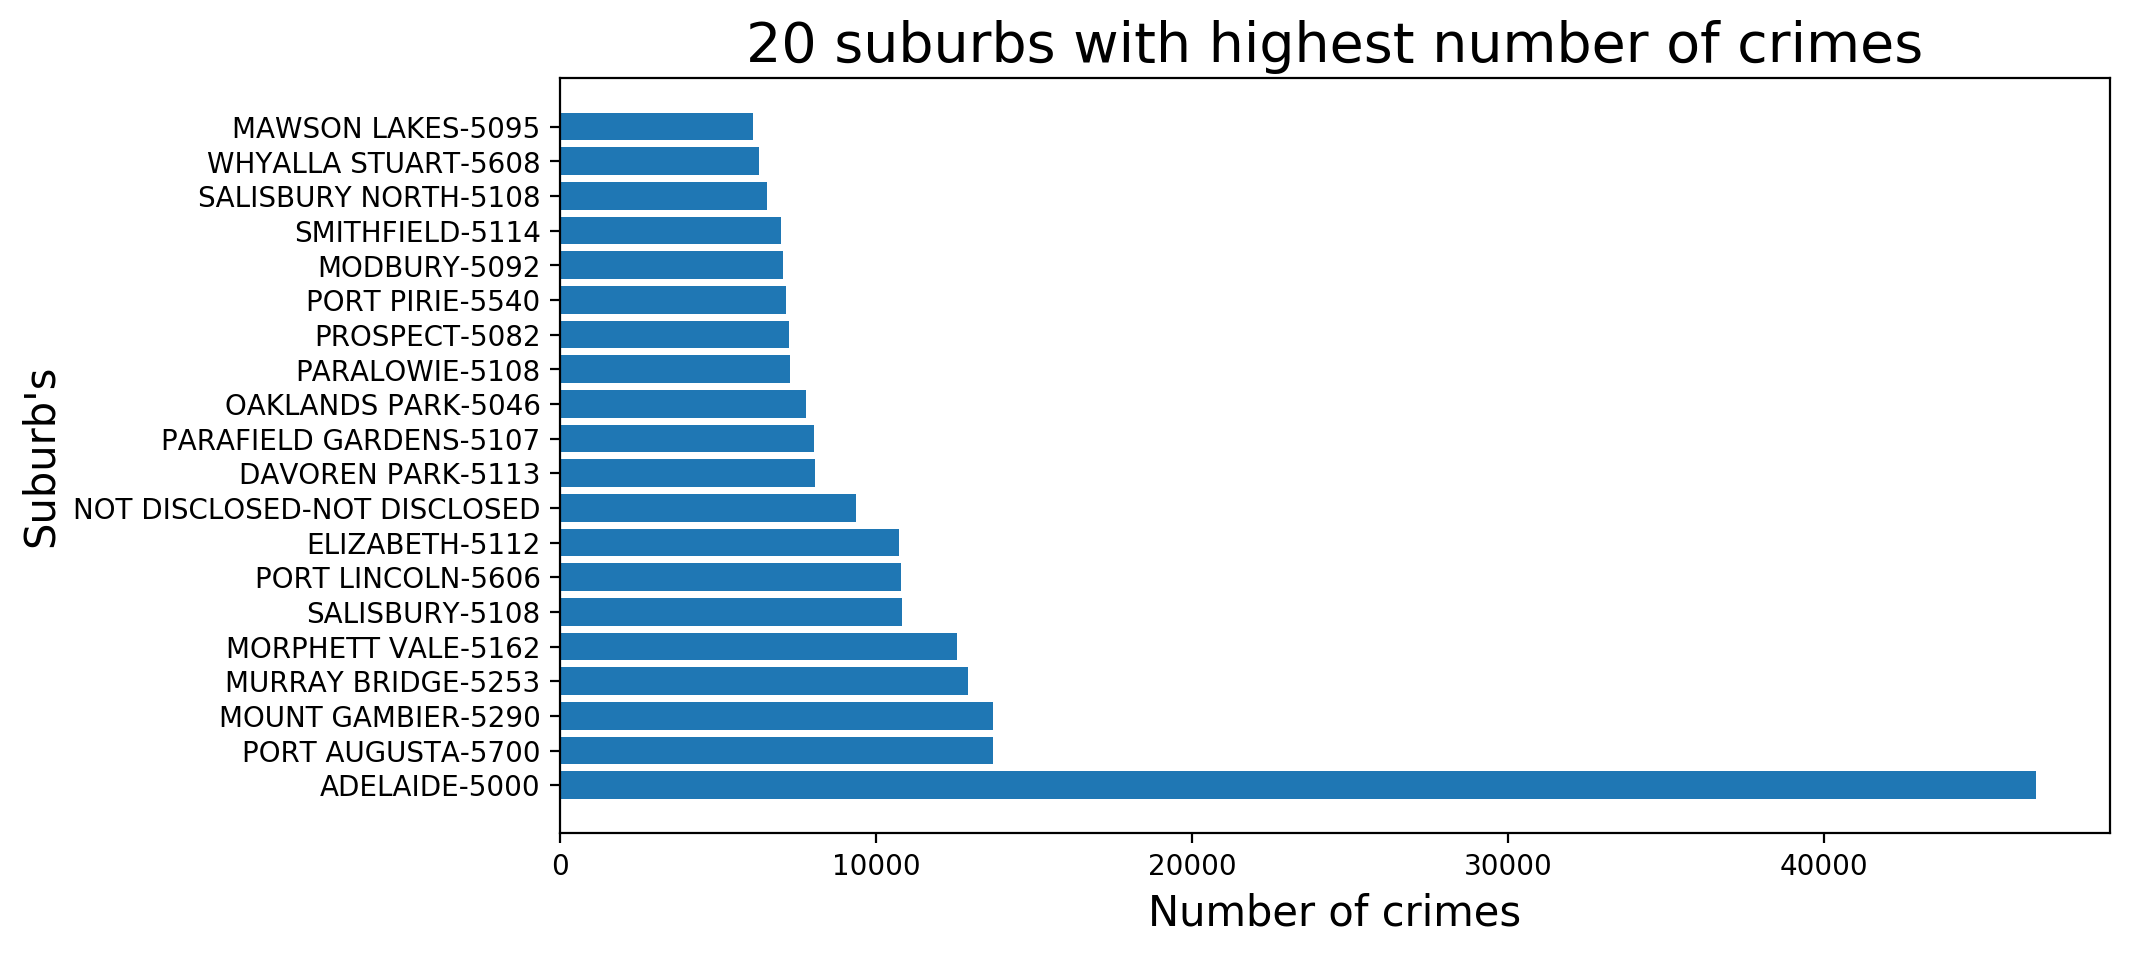

In [82]:
plt.figure(figsize=(10,5),dpi=200)
plt.barh(crime_per_suburb[0:20]['Suburb-postcode'],crime_per_suburb[0:20]['Offence Count'])
plt.xlabel('Number of crimes',fontsize=15) # x axis label
plt.ylabel('Suburb\'s',fontsize=15) # y axis label
plt.title('20 suburbs with highest number of crimes',fontsize=20) # plot title
plt.show()

* It is evident that maximum number of crimes have occured in Adelaide,46701, which is four times the second maximum(13711)

#### Find the number of serious criminal trespasses by day and month. Plot a graph and explain your understanding of the graph?

* **date_format()** method used to extract day of the week from the datetime column 'Reported Date_DateType'
* parameter 'E' passed to the method means short form conversion e.g Mon, Tue etc
* The extracted day of week is stored in a new column 'DayOfWeek'

In [53]:
crime_stat_df_mongodb = crime_stat_df_mongodb.withColumn('DayOfWeek',date_format((col('Reported Date_DateType')),'E'))


In [54]:
crime_stat_df_mongodb.groupby('DayOfWeek').count().show()

+---------+------+
|DayOfWeek| count|
+---------+------+
|      Sun| 92850|
|      Mon|119534|
|      Thu|104991|
|      Sat| 92313|
|      Wed|104870|
|      Fri|104706|
|      Tue|108143|
+---------+------+



* Data columns have been filtered for each week day, grouped by 'Month'.
* Finally total offence counts for that particular weekday in each month is stored in a new pandas dataframe

In [55]:
crime_Mon = crime_stat_df_mongodb[crime_stat_df_mongodb['DayOfWeek']=='Mon'].groupby('Month').agg(sum('Offence Count').alias('Offence Count')).sort('Month').toPandas()

In [56]:
crime_Tue = crime_stat_df_mongodb[crime_stat_df_mongodb['DayOfWeek']=='Tue'].groupby('Month').agg(sum('Offence Count').alias('Offence Count')).sort('Month').toPandas()

In [57]:
crime_Wed = crime_stat_df_mongodb[crime_stat_df_mongodb['DayOfWeek']=='Wed'].groupby('Month').agg(sum('Offence Count').alias('Offence Count')).sort('Month').toPandas()

In [58]:
crime_Thu = crime_stat_df_mongodb[crime_stat_df_mongodb['DayOfWeek']=='Thu'].groupby('Month').agg(sum('Offence Count').alias('Offence Count')).sort('Month').toPandas()

In [59]:
crime_Fri = crime_stat_df_mongodb[crime_stat_df_mongodb['DayOfWeek']=='Fri'].groupby('Month').agg(sum('Offence Count').alias('Offence Count')).sort('Month').toPandas()

In [60]:
crime_Sat = crime_stat_df_mongodb[crime_stat_df_mongodb['DayOfWeek']=='Sat'].groupby('Month').agg(sum('Offence Count').alias('Offence Count')).sort('Month').toPandas()

In [61]:
crime_Sun = crime_stat_df_mongodb[crime_stat_df_mongodb['DayOfWeek']=='Sun'].groupby('Month').agg(sum('Offence Count').alias('Offence Count')).sort('Month').toPandas()

In [88]:
crime_Sun

,Month,Offence Count
0,1,10093
1,2,8955
2,3,9852
3,4,7795
4,5,8338
5,6,7811
6,7,9395
7,8,9114
8,9,9595
9,10,9825


Text(0.5, 1.0, 'Seroius criminal trespasses by day and month')

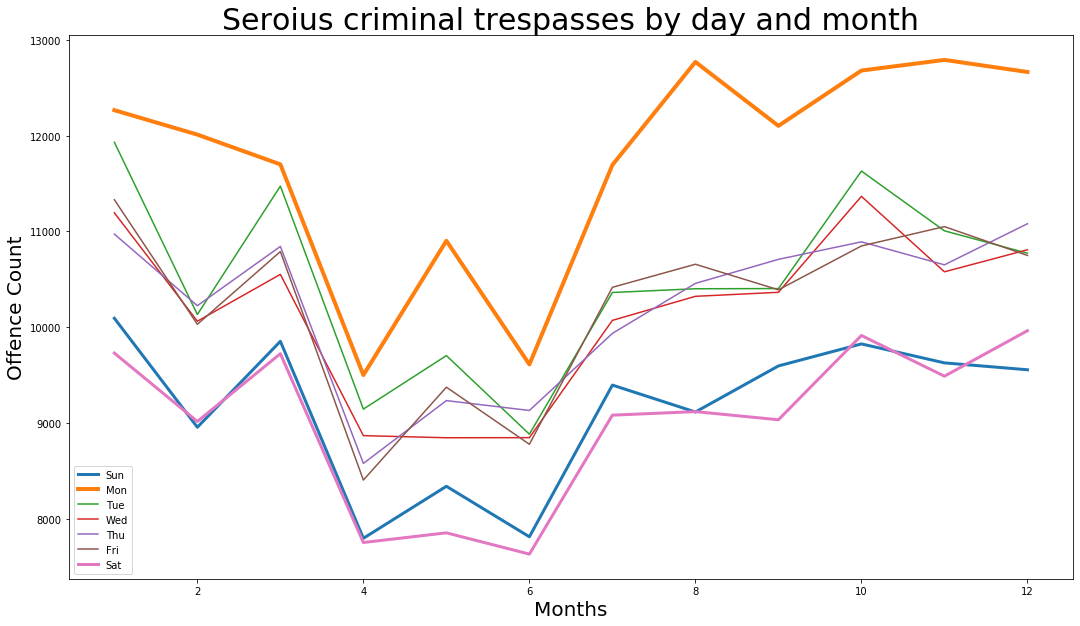

In [87]:
# plotting all the crime data sets that pertain to each day of week
plt.figure(figsize=(18,10))
plt.plot('Month','Offence Count',data=crime_Sun,label = 'Sun',linewidth=3)
plt.plot('Month','Offence Count',data=crime_Mon,label = 'Mon',linewidth=4)
plt.plot('Month','Offence Count',data=crime_Tue,label = 'Tue')
plt.plot('Month','Offence Count',data=crime_Wed,label = 'Wed')
plt.plot('Month','Offence Count',data=crime_Thu,label = 'Thu')
plt.plot('Month','Offence Count',data=crime_Fri,label = 'Fri')
plt.plot('Month','Offence Count',data=crime_Sat,label = 'Sat',linewidth=3)
plt.legend()
plt.xlabel('Months',fontsize=20)
plt.ylabel('Offence Count',fontsize=20)
plt.title('Seroius criminal trespasses by day and month',fontsize=30)

**Understanding of graph** <br>
* Monday amounts for maximum number of trespass crimes across all the months. Maximum value is during month 8
* Saturday and Sunday amount to the least offence counts across all the months
* Minimum offence counts are reported during months 4-6 on Saturday's and Sunday's
* Tue , Wed and Thr follow usual trend i.e high during months 1-4 and lowest during months 4-6.Increase can be seen again during second half of the year. 